## Exploratory Data Analysis

#### Understand the data - Clean the data - Analysis between the relationship


In [24]:
import pandas as pd

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [2]:
train_df.columns

Index(['id', 'label', 'tweet'], dtype='object')

## 1. Data Exploration
#### 1.1 Check for missing data and rectify

In [25]:
print(train_df.tweet.isna().any())
print(test_df.tweet.isna().any())

False
False


There is no missing data present.

#### 1.2 Data cleaning
* Get the hashtags
* Remove Urls
* Remove apostrophe
* encode and decode ascii (removes junk characters in the text)
* Remove punctuations
* Remove stopwords
* Keep only English language words
* Apply stemming using Porter Stemmer

In [28]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Bruce
[nltk_data]     Wayne\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [29]:
import re
import enchant
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 

train_df['cleaned_text'] = train_df['tweet']
test_df['cleaned_text'] = test_df['tweet']

# get the hashtags
def getHashTags(text):
    tags = ''
    for word in text.split():
        if word.startswith('#'):
            tags += (' ' + word[1:])
            
    return tags.strip()

train_df['hashTags'] = train_df.cleaned_text.apply(lambda row: getHashTags(row))

#remove url
# train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : ' '.join([word for word in str(text).split() if not ('http' in word or 'https' in word)]))
train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : re.sub(r'http\S+', '', text))


#remove apostrophes
def removeApostrophes(text):
    aposMap = {
        "'s": ' is',
        "'re" : ' are',
        "'m" : ' am',
        "can't" : 'cannot',
        "ain't" : 'is not',
        "n't" : ' not'
    }
    
    for apos in aposMap:
        if apos in text:
            text = text.replace(apos,aposMap[apos])
    
    return text

train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : removeApostrophes(text))


# encoding decoding
train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : text.encode('ascii','ignore').decode('ascii'))


#remove punctuations
def removePunctuations(text):
    modifiedText = re.sub(r'[^\w\s]','',text)
    modifiedText = re.sub(r'[0-9]','',modifiedText)    
    
    return modifiedText

train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda row: removePunctuations(row))


#remove stopwords
stop_words = set(stopwords.words('english')) 
train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : ' '.join([word for word in text.split() if not word in stop_words]))

train_df.cleaned_text = train_df.cleaned_text.str.replace('user', '')


# extract only english words
english_dict = enchant.Dict("en_US")
train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : ' '.join([word for word in text.split() if english_dict.check(word)]))


# stemming / lemmatizer
# I choose lemmatizing over here.
lemmatizer = WordNetLemmatizer() 
train_df['cleaned_text'] = train_df.cleaned_text.apply(lambda text : ' '.join([lemmatizer.lemmatize(word) for word in text.split()]))

In [34]:
lemmatizer.lemmatize('Rocks')

'Rocks'

#### 1.3 Target Distribution

   label     id  Percentage
0      0  29720    92.98542
1      1   2242     7.01458


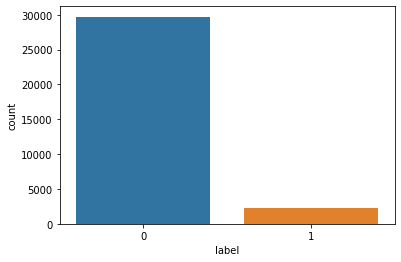

In [18]:
import seaborn as sns
labelGroup_df = train_df.groupby(['label']).count()
labelGroup_df.reset_index(inplace = True)
labelGroup_df = labelGroup_df[['label','id']]
total = labelGroup_df.id.sum()
labelGroup_df['Percentage'] = labelGroup_df.id.apply(lambda count:100*(count/total))

# sns.barplot(x='label',y='Percentage', data = labelGroup_df)
sns.countplot(x='label', data = train_df)
print(labelGroup_df)

Observation:
We have a dataset imbalance here.
Event rate = 7%

We have to re-sample the data to lower the imbalance here.

We can't rely on accuracy alone as a metric for evaluation. Rather F1 score should suffice our need.


In [38]:
import numpy as np
METAFEATURES = []

# word count
train_df['word_count'] = train_df['tweet'].apply(lambda tweet: len(str(tweet).split()))
test_df['word_count'] = test_df['tweet'].apply(lambda tweet: len(str(tweet).split()))
METAFEATURES.append('word_count')

# unique_word_count
train_df['unique_word_count'] = train_df.tweet.apply(lambda tweet: len(set(str(tweet).split())))
test_df['unique_word_count'] = test_df.tweet.apply(lambda tweet: len(set(str(tweet).split())))
METAFEATURES.append('unique_word_count')

# stop_word_count
train_df['stopword_count'] = train_df.tweet.apply(lambda tweet: len([word for word in str(tweet).split() if word in stop_words]))
test_df['stopword_count'] = test_df.tweet.apply(lambda tweet: len([word for word in str(tweet).split() if word in stop_words]))
METAFEATURES.append('stopword_count')

# url_count
train_df['url_count'] = train_df.tweet.apply(lambda tweet: len([word for word in tweet.split() if ('https' in word or 'http' in word)]))
test_df['url_count'] = test_df.tweet.apply(lambda tweet: len([word for word in tweet.split() if ('https' in word or 'http' in word)]))
METAFEATURES.append('url_count')

#mean_word_length
train_df['mean_word_length'] = train_df.tweet.apply(lambda tweet: np.mean([len(word) for word in tweet.split()]))
test_df['mean_word_length'] = test_df.tweet.apply(lambda tweet: np.mean([len(word) for word in tweet.split()]))
METAFEATURES.append('mean_word_length')

# char count
train_df['char_count'] = train_df.tweet.apply(lambda tweet: len(str(tweet)))
test_df['char_count'] = test_df.tweet.apply(lambda tweet: len(str(tweet)))
METAFEATURES.append('char_count')

# hashtag_count
train_df['hashtag_count'] = train_df['tweet'].apply(lambda tweet: len([word for word in str(tweet) if word == '#']))
test_df['hashtag_count'] = test_df['tweet'].apply(lambda tweet: len([word for word in str(tweet) if word == '#']))
METAFEATURES.append('hashtag_count')

# mention_count
train_df['mention_count'] = train_df['tweet'].apply(lambda tweet: len([word for word in str(tweet) if word == '@']))
test_df['mention_count'] = test_df['tweet'].apply(lambda tweet: len([word for word in str(tweet) if word == '@']))
METAFEATURES.append('mention_count')

F:\InstalledPrograms\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
F:\InstalledPrograms\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
F:\InstalledPrograms\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
F:\InstalledPrograms\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


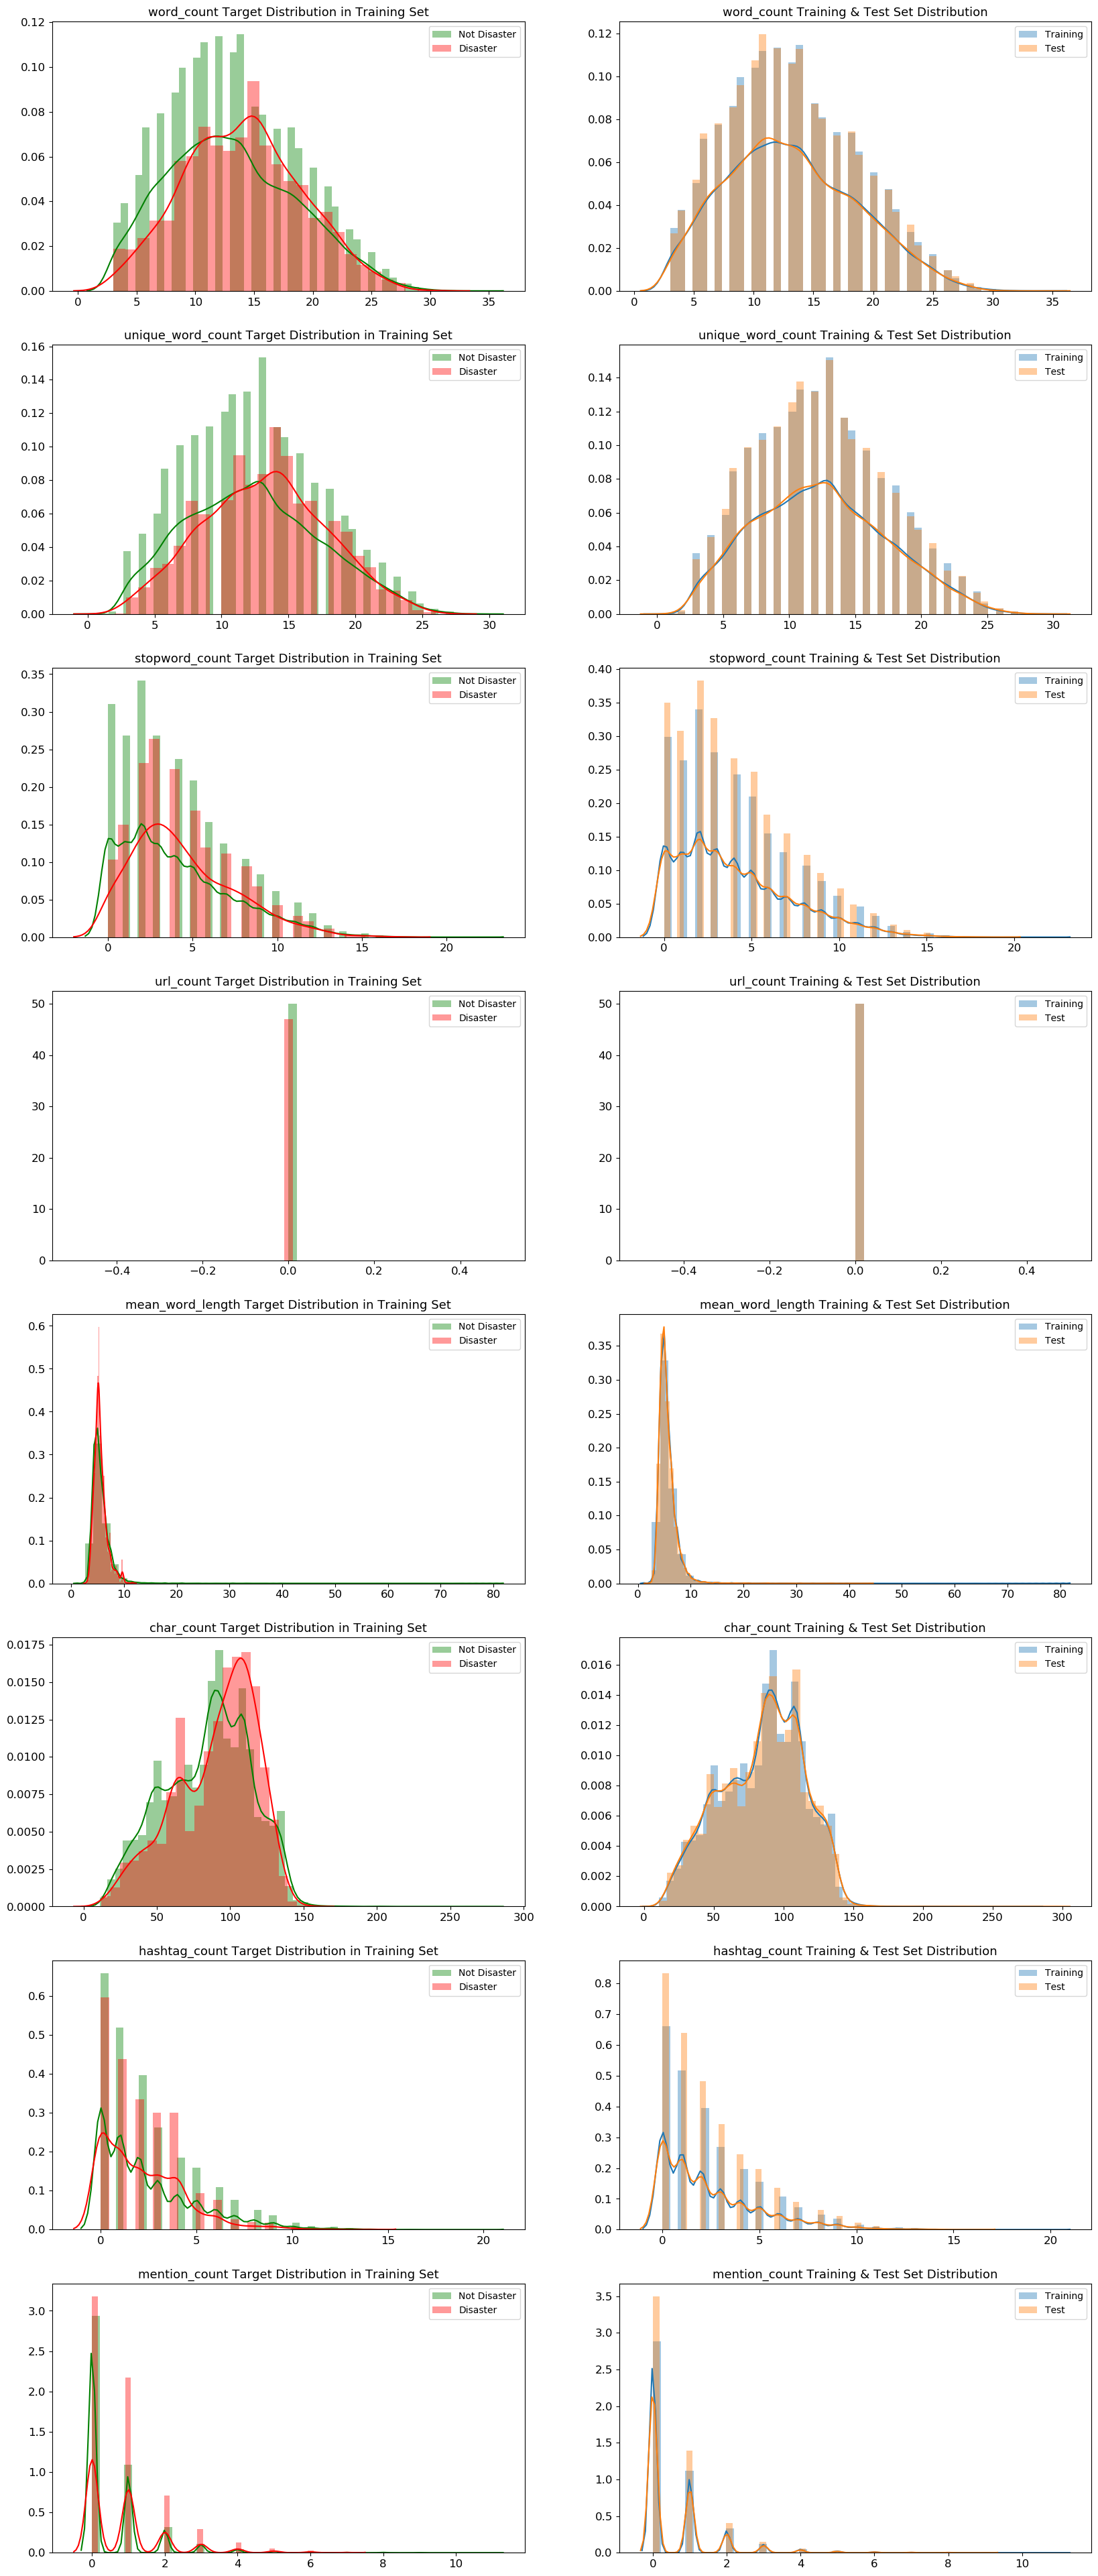

In [40]:
import matplotlib.pyplot as plt
HateSpeechTweets = train_df['label'] == 1

fig, axes = plt.subplots(ncols = 2, nrows = len(METAFEATURES), figsize = (20,50), dpi = 100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~HateSpeechTweets][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_df.loc[HateSpeechTweets][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_df[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_df[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [39]:
DISASTER_TWEETS = train_df['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_df[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_df[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

['word_count',
 'unique_word_count',
 'stopword_count',
 'url_count',
 'mean_word_length',
 'char_count',
 'hashtag_count',
 'mention_count']